<a id="top"></a>
# Exploring Stellar Spectra with SDSS SEGUE
***
## Learning Goals

By the end of this tutorial, you will:

- Understand how to use `astroquery.mast` to download data from the SDSS Legacy Spectra and SEGUE surveys
- Plot a stellar spectrum and label absorption lines
- Learn about OBAFGKM spectral classification and how to classify stars

## Table of Contents
* [Introduction](#Introduction)
* [Imports](#Imports)
* [Accessing SDSS Legacy Spectra Data from MAST](#Accessing-SDSS-Legacy-Spectra-Data-from-MAST)
  * [Querying the SDSS Legacy Spectra Survey](#Querying-the-SDSS-Legacy-Spectra-Survey)
  * [Downloading Data Products](#Downloading-Data-Products)
* [Plotting a Spectrum](#Plotting-a-Spectrum)
  * [Adding Labels for Absorption Lines](#Adding-Labels-for-Absorption-Lines)
  * [Enhancing the Plot](#Enhancing-the-Plot)
* [Exploring Different Stellar Classifications](#Exploring-Different-Stellar-Classifications)
* [Exercise: Classifying a Random Star](#Exercise:-Classifying-a-Random-Star)
  * [Exercise Solutions](#Exercise-Solutions)
* [Additional Resources](#Additional-Resources)


## Introduction

The SDSS Legacy Spectra Survey is an optical-wavelength spectroscopic survey of millions of stars, galaxies, and quasars available through the [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss). This includes data from the original [SDSS Legacy Spectra](https://classic.sdss.org/legacy/) survey, the [SDSS Supernova Survey](https://www.sdss4.org/surveys/supernova/), and the [Sloan Extension for Galactic Understanding and Exploration (SEGUE)](https://www.sdss4.org/surveys/segue/), which targeted over 400,000 stars in the Milky Way with a goal of mapping out the galactic disk in abundance space. A summary of the SDSS data products available at MAST can be found in the [SDSS Legacy Archive at MAST User Manual](https://outerspace.stsci.edu/display/SDSS/Legacy+Spectra+Data+Products).

The primary data products from the SDSS Legacy Spectra survey and SEGUE extensions are optical-wavelength (380-920 nm) spectra with a resolution of (λ/δλ)~2000 obtained using the SDSS-I/-II Spectrograph on the SDSS-2.5m telescope (Gunn et al. 2006) at Apache Point Observatory. In this notebook, we will show how to download SEGUE data from MAST, plot a spectrum, and classify a star based on its spectral type!

In 1912, astronomer Annie Jump Cannon developed a method to classify stars based on the appearance of their spectrum, which is still used today. Stars are classified as O, B, A, F, G, K, or M based on the strength and location of absorption lines in their spectrum. [[1]](https://articles.adsabs.harvard.edu/pdf/1912AnHar..56..115C) These classifications also correspond to stellar temperature: O-type stars are the hottest stars, with surface temperatures of >30,000 K, while M-type have the coldest temperatures of < 3000 K. Our Sun is a G-type star. In this notebook, we will explore different stellar types and what their spectra look like. 


## Imports
The main packages and their use-cases in this tutorial are as follows:

- *numpy* to handle array functions and some basic math
- *matplotlib* for plotting data and creating figures
- *astropy.io* for reading FITS files
- *astroquery.mast* to search and download data from MAST


In [1]:
%matplotlib inline

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from astropy.io import fits
from astropy.table import Table

from astroquery.mast import Observations

If you're not sure whether you have these packages installed on your device, you can uncomment and run the following cell to install the required versions:

In [2]:
# !pip install -r requirements.txt

This cell updates some of the settings in `matplotlib` to use larger font sizes in the figures:

In [3]:
# Update Plotting Parameters
params = {
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
    "lines.linewidth": 1,
    "axes.titlesize": 18,
    "font.family": "serif",
    "font.size": 12,
}
plt.rcParams.update(params)

***

## Accessing SDSS Legacy Spectra Data from MAST 

In this tutorial, we will be focusing on data from the [Sloan Extension for Galactic Understanding and Exploration (SEGUE)](https://www.sdss4.org/surveys/segue/) to plot the spectra of different types of stars and learn about stellar classification. Accessing data from the [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss) is easy using [astroquery.MAST](https://astroquery.readthedocs.io/en/latest/mast/mast.html), a Python package module for querying the MAST archive.


### Querying the SDSS Legacy Spectra Survey

To search the SDSS Spectra Data available through MAST, we can use the `Observations.query_criteria()` function and search for the provenance name "SEGUE" to return all data from the SEGUE survey:

In [4]:
# Query for SDSS SEGUE Data
spectro_data = Observations.query_criteria(
    provenance_name="SEGUE", pagesize=10, page=1
)

# Display first 10 entries
spectro_data

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str17,str4,str4,str7,str19,str4,str28,float64,float64,str8,str18,int64,float64,float64,float64,float64,float64,str51,float64,str3,str1,int64,str48,str69,str64,str6,bool,float64,str9,str10
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 3292-54943-152,STAR,sdss_spectro_3292-54943-0152,261.33779,35.212895,spectrum,SDSS Collaboration,3,54941.44521990741,54943.45390046296,6300.0,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,55572.0,N/A,--,--,CIRCLE 261.33779 35.212895 0.0004166666666666667,mast:SDSS/sdss/spectro/3292/54943/0152/spec-image-3292-54943-0152.png,mast:SDSS/sdss/spectro/3292/54943/0152/spec-3292-54943-0152.fits,PUBLIC,False,nan,353720760,1012687679
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 2541-54481-505,STAR,sdss_spectro_2541-54481-0505,130.77624,83.816927,spectrum,SDSS Collaboration,3,54481.31706018518,54481.36547453704,3303.0,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,54770.0,N/A,--,--,CIRCLE 130.77624 83.816927 0.0004166666666666667,mast:SDSS/sdss/spectro/2541/54481/0505/spec-image-2541-54481-0505.png,mast:SDSS/sdss/spectro/2541/54481/0505/spec-2541-54481-0505.fits,PUBLIC,False,nan,353625656,1012687700
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 3292-54943-157,STAR,sdss_spectro_3292-54943-0157,261.28304,35.0749,spectrum,SDSS Collaboration,3,54941.44521990741,54943.45390046296,6300.0,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,55572.0,N/A,--,--,CIRCLE 261.28304 35.0749 0.0004166666666666667,mast:SDSS/sdss/spectro/3292/54943/0157/spec-image-3292-54943-0157.png,mast:SDSS/sdss/spectro/3292/54943/0157/spec-3292-54943-0157.fits,PUBLIC,False,nan,353720783,1012687727
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 3292-54943-159,STAR,sdss_spectro_3292-54943-0159,261.21166,34.934269,spectrum,SDSS Collaboration,3,54941.44521990741,54943.45390046296,6300.0,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,55572.0,N/A,--,--,CIRCLE 261.21166 34.934269 0.0004166666666666667,mast:SDSS/sdss/spectro/3292/54943/0159/spec-image-3292-54943-0159.png,mast:SDSS/sdss/spectro/3292/54943/0159/spec-3292-54943-0159.fits,PUBLIC,False,nan,353720791,1012687759
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 2541-54481-515,STAR,sdss_spectro_2541-54481-0515,132.2201,83.828086,spectrum,SDSS Collaboration,3,54481.31706018518,54481.36547453704,3303.0,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,54770.0,N/A,--,--,CIRCLE 132.2201 83.828086 0.0004166666666666667,mast:SDSS/sdss/spectro/2541/54481/0515/spec-image-2541-54481-0515.png,mast:SDSS/sdss/spectro/2541/54481/0515/spec-2541-54481-0515.fits,PUBLIC,False,nan,353625699,1012687993
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 2697-54389-49,STAR,sdss_spectro_2697-54389-0049,57.655695,9.13494,spectrum,SDSS Collaboration,3,54389.31576388889,54389.43258101852,8857.0,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,54770.0,N/A,--,--,CIRCLE 57.655695 9.13494 0.0004166666666666667,mast:SDSS/sdss/spectro/2697/54389/0049/spec-image-2697-54389-0049.png,mast:SDSS/sdss/spectro/2697/54389/0049/spec-2697-54389-0049.fits,PUBLIC,False,nan,353621463,1012688026
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 2541-54481-521,STAR,sdss_spectro_2541-54481-0521,127.15832,84.383137,spectrum,SDSS Collaboration,3,54481.31706018518,54481.36547453704,3303.0,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,54770.0,N/A,--,--,CIRCLE 127.15832 84.383137 0.0004166666666666667,mast:SDSS/sdss/spectro/2541/54481/0521/spec-image-2541-54481-0521.png,mast:SDSS/sdss/spect

The table above provides some basic information for each observation:
- `collection`: Tells us the mission for this data, which is `SDSS`
- `s_ra` and `s_dec`: Celestial coordinates right ascension and declination.
- `instrument_name`: `SDSS Spectrograph` indicates that the data were collected using the SDSS Spectrograph instrument. This would be a good field to search on if you are interested in both the SEGUE survey and the original SDSS Legacy Spectra survey.
- `obs_id`: Observation ID associated with the object. This is based on the plate number, the modified Julian date of observation, and the fiber ID, so the observation ID will look something like `sdss_spectro_{PLATE}-{MJD}-{FIBERID}`.
- `target_classification`: Indicates the type of object (`QSO`, `STAR`, or `GALAXY`).
- `t_min` and `t_max`: The modified Julian dates indicating the start and end times of the exposures.
- `wavelength_region`: Indicates the region of the electromagnetic spectrum observed. In this case, `OPTICAL`, since SDSS observed in the optical wavelength range.
- `em_min` and `em_max`: The minimum and maximum wavelengths observed by the survey. For SDSS, this range is 380-920.0 nanometers (optical).


### Downloading Data Products


Let's narrow down our search by querying for the observation ID of `obs_id='sdss_spectro_1660-53230-0023'`. This star was selected for this tutorial because it is a G2 type main sequence star, very similar to the Sun.

In [5]:
# Search for sun-like star "sdss_spectro_1660-53230-0023"
spectro_data = Observations.query_criteria(
    provenance_name="SEGUE", obs_id="sdss_spectro_1660-53230-0023"
)

# Display result
spectro_data

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str17,str4,str4,str7,str18,str4,str28,float64,float64,str8,str18,int64,float64,float64,float64,float64,float64,str51,float64,str3,str1,int64,str48,str69,str64,str6,bool,float64,str9,str10
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 1660-53230-23,STAR,sdss_spectro_1660-53230-0023,308.81669,76.546953,spectrum,SDSS Collaboration,3,53228.37946759259,53230.350231481476,3000.3,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,54770.0,N/A,--,--,CIRCLE 308.81669 76.546953 0.0004166666666666667,mast:SDSS/sdss/spectro/1660/53230/0023/spec-image-1660-53230-0023.png,mast:SDSS/sdss/spectro/1660/53230/0023/spec-1660-53230-0023.fits,PUBLIC,False,nan,355050660,1016516519


Using `Observations.get_product_list()`, we can get the list of files associated with this star that are available to download:

In [6]:
# View available products for first observation
products = Observations.get_product_list(spectro_data[0])
# List Products
products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str9,str4,str12,str31,str252,str1,str69,str7,str28,str13,str48,str19,str4,str3,str30,int64,str9,str6,int64,str4
355050660,SDSS,spectrum,sdss_spectro_1660-53230-0023,Preview-Full,S,mast:SDSS/sdss/spectro/1660/53230/0023/spec-image-1660-53230-0023.png,PREVIEW,--,--,--,SEGUE,dr7,N/A,spec-image-1660-53230-0023.png,33778,355050660,PUBLIC,3,None
355050660,SDSS,spectrum,sdss_spectro_1660-53230-0023,SDSS Legacy Spectra lite spectrum file containing the combined spectrum and associated metadata but not the individual exposures.,S,mast:SDSS/sdss/spectro/1660/53230/0023/spec-lite-1660-53230-0023.fits,SCIENCE,--,SPECTRA,https://archive.stsci.edu/missions-and-data/sdss,SEGUE,dr7,N/A,spec-lite-1660-53230-0023.fits,172800,355050660,PUBLIC,3,None
355050660,SDSS,spectrum,sdss_spectro_1660-53230-0023,"SDSS Legacy Spectra full spectrum file containing the combined spectrum, associated metadata, and the individual exposures.",S,mast:SDSS/sdss/spectro/1660/53230/0023/spec-1660-53230-0023.fits,SCIENCE,Minimum Recommended Products,SPECTRA,https://archive.stsci.edu/missions-and-data/sdss,SEGUE,dr7,N/A,spec-1660-53230-0023.fits,604800,355050660,PUBLIC,3,None
355053097,SDSS,measurements,sdss_spectro_spplate_1660-53230,"SDSS Legacy Spectra summary catalog, for each plate-MJD, containing the combined spectra and targeting information for all observations on a single plate.",D,mast:SDSS/sdss/spectro/1660/53230/spPlate-1660-53230.fits,SCIENCE,--,SDSS Catalogs,https://archive.stsci.edu/missions-and-data/sdss,SDSS Legacy Spectra,DR17,N/A,spPlate-1660-53230.fits,59708160,355050660,PUBLIC,3,--
355053113,SDSS,measurements,sdss_spectro_spzall_1660-53230,"SDSS Legacy Spectra summary catalog, for each plate-MJD, containing the best fits for spectral redshift and classification measurements, rank-ordered by chi-squared. If the best fit looks bad from the SpecObj file, check the second best fit here.",D,mast:SDSS/sdss/spectro/1660/53230/spZall-1660-53230.fits,SCIENCE,--,SDSS Catalogs,https://archive.stsci.edu/missions-and-data/sdss,SDSS Legacy Spectra,DR17,N/A,spZall-1660-53230.fits,31164480,355050660,PUBLIC,3,--
355581403,SDSS,measurements,sdss_spectro_specobj,"SDSS Legacy Spectra summary catalog. This provides collated summary tables on the observations and data processing from the SDSS Legacy Spectra survey, including targeting information, spectroscopic classifications, and redshifts for every observation.",D,mast:SDSS/sdss/spectro/specObj-dr17.fits,SCIENCE,--,SDSS Catalogs,https://archive.stsci.edu/missions-and-data/sdss,SDSS Legacy Spectra,DR17,N/A,specObj-dr17.fits,6741023040,355050660,PUBLIC,3,--


For this star, we can see quite a few files available:
- `spec-image-1660-53230-0023.png`: A png image with preview of each spectrum
- `spec-1660-53230-0023.fits`: The "full" spectrum file, which contains the combined spectrum, associated metadata, and the individual exposures.
- `spec-lite-1660-53230-0023.fits`: The "lite" version of the spectrum file, which contains the combined spectrum and associated metadata but not the individual exposures.
- Two catalog files, `spPlate-1660-53230.fits` and `spZall-1660-53230.fits`, which contain observing information, measurements, and metadata for all spectra observed on the same plate.

More detail on the data products available for SEGUE can be found on the [Legacy Spectra Data Products page of the Archive User Manual](https://outerspace.stsci.edu/display/SDSS/Legacy+Spectra+Data+Products).

For this tutorial, we will only use the full spectrum file, which is the *Minimum Recommended Product* according to the `productGroupDescription`. Downloading this file is simple using `Observations.download_products()`:

In [7]:
# Downloading spectrum files
manifest = Observations.download_products(
    products,  # Specify a product list to download
    flat=True,  # Download with a "flat" structure in the current directory
    mrp_only=True,  # Limit to Minimum Recommended Products = the full spectrum file
)

 [Done]


***

## Plotting a Spectrum

Now that we know how to download spectra from the SDSS Legacy Archive at MAST, let's take a closer look at the data. We can print some basic information about the file we just downloaded by opening the data with `astropy.io.fits` and printing the file summary with `.info()`

In [8]:
# Opening file
spectrum_file = fits.open(manifest["Local Path"][0])

# Display file info
spectrum_file.info()

Filename: ./spec-1660-53230-0023.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     128   ()      
  1  COADD         1 BinTableHDU     26   3837R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   
  4  B1-00027775-00027772-00027774    1 BinTableHDU    146   2044R x 7C   [E, E, E, J, E, E, E]   
  5  B1-00027776-00027772-00027774    1 BinTableHDU    1

This file has various extensions, which are explained in the [SDSS Data Model](https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/full/PLATE4/spec.html):
- `HDU 0: PRIMARY`: The primary header information. 
- `HDU 1: COADD`: The coadded observed spectrum.
- `HDU 2: SPECOBJ`: Metadata from the SPECOBJ table, which includes targeting information and spectroscopic classifications from the [SDSS Spectra Data Reduction Pipeline](https://www.sdss4.org/dr17/spectro/pipeline/).
- `HDU 3: SPZLINE`: Measurements and line fitting outputs from the [SDSS Spectra Data Analysis Pipeline](https://classic.sdss.org/segue/stellarpars.php), which measures chemical abundances and equivalent widths for absorption lines in the spectrum.
- `HDU 4+`: Individual visit spectra (on red `R1-` and blue `B1-` ccd chips) that were included in the coadded spectrum. 


Now, let's plot the spectrum with `matplotlib.pyplot`. To do this, we'll use the information in the first extension (`COADD`). This extension contains the wavelength and flux information we will need to make a plot.

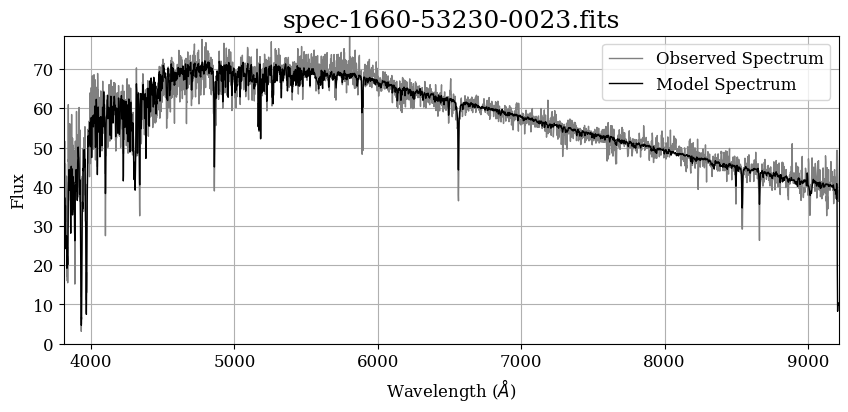

In [9]:
# Initiate plot
plt.figure(figsize=(10, 4))

# Load in wavelength and flux
wavelength = 10 ** spectrum_file["COADD"].data["loglam"]
observed_flux = spectrum_file["COADD"].data["FLUX"]
model_flux = spectrum_file["COADD"].data["MODEL"]

# Plot Observed Spectrum
plt.plot(wavelength, observed_flux, c="gray", label="Observed Spectrum")
# Plot Best-fit Model Spectrum
plt.plot(wavelength, model_flux, c="k", label="Model Spectrum")

# Label axes
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Flux")
plt.title(f"{spectrum_file.filename().strip('./')}")
plt.grid()
plt.legend()


# Set axes limits
plt.xlim(np.min(wavelength), np.max(wavelength))
plt.ylim(0, np.max(observed_flux))

# Show plot
plt.show()

### Adding Labels for Absorption Lines

That's a good-looking spectrum! But as we saw earlier, the spectrum is not the only information in this file: The SDSS [Data Reduction Pipeline](https://www.sdss4.org/dr17/spectro/pipeline/) and [SEGUE Stellar Parameter Pipeline (SSPP)](https://classic.sdss.org/segue/stellarpars.php) have made various measurements of this star, which are availble in the "SPECOBJ" and "SPZLINE" extensions of this file.

In [10]:
# Display table from the "SPECOBJ" extension
Table(spectrum_file["SPECOBJ"].data)

SURVEY,INSTRUMENT,CHUNK,PROGRAMNAME,PLATERUN,PLATEQUALITY,PLATESN2,DEREDSN2,LAMBDA_EFF,BLUEFIBER,ZOFFSET,SNTURNOFF,NTURNOFF,SPECPRIMARY,SPECLEGACY,SPECSEGUE,SPECSEGUE1,SPECSEGUE2,SPECBOSS,BOSS_SPECOBJ_ID,SPECOBJID,FLUXOBJID,BESTOBJID,TARGETOBJID,PLATEID,NSPECOBS,FIRSTRELEASE,RUN2D,RUN1D,DESIGNID,CX,CY,CZ,XFOCAL,YFOCAL,SOURCETYPE,TARGETTYPE,PRIMTARGET,SECTARGET,LEGACY_TARGET1,LEGACY_TARGET2,SPECIAL_TARGET1,SPECIAL_TARGET2,SEGUE1_TARGET1,SEGUE1_TARGET2,SEGUE2_TARGET1,SEGUE2_TARGET2,MARVELS_TARGET1,MARVELS_TARGET2,BOSS_TARGET1,BOSS_TARGET2,ANCILLARY_TARGET1,ANCILLARY_TARGET2,SPECTROGRAPHID,PLATE,TILE,MJD,FIBERID,OBJID,PLUG_RA,PLUG_DEC,CLASS,SUBCLASS,Z,Z_ERR,RCHI2,DOF,RCHI2DIFF,TFILE,TCOLUMN,NPOLY,THETA,VDISP,VDISP_ERR,VDISPZ,VDISPZ_ERR,VDISPCHI2,VDISPNPIX,VDISPDOF,WAVEMIN,WAVEMAX,WCOVERAGE,ZWARNING,SN_MEDIAN_ALL,SN_MEDIAN,CHI68P,FRACNSIGMA,FRACNSIGHI,FRACNSIGLO,SPECTROFLUX,SPECTROFLUX_IVAR,SPECTROSYNFLUX,SPECTROSYNFLUX_IVAR,SPECTROSKYFLUX,ANYANDMASK,ANYORMASK,SPEC1_G,SPEC1_R,SPEC1_I,SPEC2_G,SPEC2_R,SPEC2_I,ELODIE_FILENAME,ELODIE_OBJECT,ELODIE_SPTYPE,ELODIE_BV,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,ELODIE_Z,ELODIE_Z_ERR,ELODIE_Z_MODELERR,ELODIE_RCHI2,ELODIE_DOF,Z_NOQSO,Z_ERR_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,RCHI2DIFF_NOQSO,Z_PERSON,CLASS_PERSON,Z_CONF_PERSON,COMMENTS_PERSON,CALIBFLUX,CALIBFLUX_IVAR
str6,str4,str16,str23,str16,str8,float32,float32,float32,int32,float32,float32,int32,uint8,uint8,uint8,uint8,uint8,uint8,int32,str22,str19,str19,str22,str19,int16,str3,str3,str1,int32,float64,float64,float64,float32,float32,str19,str8,int32,int32,int32,int32,int64,int64,int32,int32,int32,int32,int32,int32,int64,int64,int64,int64,int16,int32,int32,int32,int32,int32[5],float64,float64,str6,str21,float32,float32,float32,int32,float32,str24,int32[10],int32,float32[10],float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,int32,float32,float32[5],float32,float32[10],float32[10],float32[10],float32[5],float32[5],float32[5],float32[5],float32[5],int32,int32,float32,float32,float32,float32,float32,float32,str25,str21,str10,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,str1,str1,float32,float32,int32,int32,str1,float32[5],float32[5]
segue1,SDSS,chunk83,segtest,dr2003.11.4,good,11.8604,0.0,5000.0,-1,0.0,-9999.0,0,0,0,0,0,0,0,0,1869000221741049856,1237663268800036929,1237663268800036929,11276799565103250,1868993899549190144,2,dr7,26,,-1,0.14583121053457282,-0.18126929225275132,0.972560898720593,263.0591,-125.98856,NONLEGACY,STANDARD,0,32,0,0,0,0,0,32,0,0,0,0,0,0,0,0,1,1660,9491,53230,23,4144 .. 146,308.81669,76.546953,STAR,G2,-0.0004023878,1.0467806e-05,1.2282627,3751,1.3327496,spEigenStar-54474.fits,11 .. -1,4,34.26533 .. 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3808.9038,9212.978,0.3761,0,29.035696,5.2309275 .. 22.178715,1.0413648,0.33741027 .. 0.0013294336,0.18372773 .. 0.0013294336,0.15368253 .. 0.0,59.69679 .. 300.38974,0.575326 .. 0.26740238,43.598114 .. 292.43835,1.7917618 .. 0.29302025,17.428034 .. 67.41946,159383552,262078464,14.425,14.2167,11.8604,14.4769,19.5395,16.9398,RAC/L/00661.fits,HD176303,F8V,0.491,6107.0,4.22,-0.09,-0.00038621097,8.263349e-06,2.3138857e-06,0.86781526,2127,0.0,0.0,0,,,0.0,0.0,0,0,,39.980957 .. 318.95468,1.192785 .. 0.028415708


This table contains a lot of useful information, including the coordinates (`PLUG_RA` and `PLUG_DEC`), the date of observation (`MJD`), the data release number (`FIRSTRELEASE`), and the signal-to-noise ratio (`SN_MEDIAN_ALL`) for this spectrum.

It also includes the spectrum's classification (`CLASS`), which is typically either `STAR`, `GALAXY`, or `QSO`, and the `SUBCLASS`, which in this case, is the spectral OBAFGKM classification for this spectrum. The subclass tells us that this star is a "G2"-type star, the same stellar type as our Sun:

In [11]:
spectrum_file["SPECOBJ"].data["SUBCLASS"][0]

'G2'

The `SPZLINE` table in the file contains measurements of absorption lines in the spectrum:

In [12]:
# Display table from the "SPZLINE" extension
Table(spectrum_file["SPZLINE"].data)

PLATE,MJD,FIBERID,LINENAME,LINEWAVE,LINEZ,LINEZ_ERR,LINESIGMA,LINESIGMA_ERR,LINEAREA,LINEAREA_ERR,LINEEW,LINEEW_ERR,LINECONTLEVEL,LINECONTLEVEL_ERR,LINENPIXLEFT,LINENPIXRIGHT,LINEDOF,LINECHI2
int32,int32,int32,str13,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,float32,float32
1660,53230,23,Ly_alpha,1215.67,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0,0,0.0,-1.0
1660,53230,23,N_V 1240,1240.81,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0,0,0.0,-1.0
1660,53230,23,C_IV 1549,1549.48,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0,0,0.0,-1.0
1660,53230,23,He_II 1640,1640.42,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0,0,0.0,-1.0
1660,53230,23,C_III] 1908,1908.734,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0,0,0.0,-1.0
1660,53230,23,Mg_II 2799,2800.3151836549728,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0,0,0.0,-1.0
1660,53230,23,[O_II] 3725,3727.091726797987,-0.0003131109,0.00014917232,11562.1045,629.5375,9906.212,488720.4,0.0,-1.0,-8.457133,-1.0,0,407,405.9039,444.59473
1660,53230,23,[O_II] 3727,3729.875447997208,-0.00031311187,0.00014917232,11562.1045,629.5375,-6021.164,491477.6,0.0,-1.0,-8.457133,-1.0,0,411,409.9039,448.50122
1660,53230,23,[Ne_III] 3868,3869.8567972272717,-0.00031314234,0.00014917231,11562.1045,629.5375,-520.9457,9767.851,-12.171348,228.23471,42.800987,0.067313716,68,503,569.9039,703.04047


Let's recreate the plot we just made, but add annotations for all of the Hydrogen lines from this table.

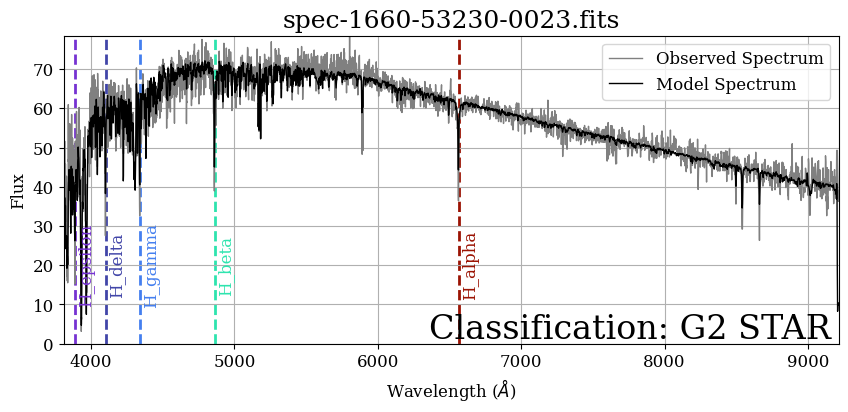

In [13]:
# Initiate plot
fig, ax = plt.subplots(figsize=(10, 4))

wavelength = 10 ** spectrum_file["COADD"].data["loglam"]
observed_flux = spectrum_file["COADD"].data["FLUX"]
model_flux = spectrum_file["COADD"].data["MODEL"]

plt.plot(wavelength, observed_flux, c="gray", label="Observed Spectrum")
plt.plot(wavelength, model_flux, c="k", label="Model Spectrum")

plt.grid()

# Define a custom rainbow colormap to use for the spectrum
rainbow_colormap = LinearSegmentedColormap.from_list(
    "",
    ["blueviolet"] + [mpl.cm.turbo(x) for x in np.linspace(0.07, 0.999, 10)],
)

# Loop through absorption lines and choose a few to label
for absorption_line in spectrum_file["SPZLINE"].data:
    line_wl = absorption_line["LINEWAVE"]  # wavelength of absorption line
    line_name = absorption_line["LINENAME"]  # name of absorption line
    if "H_" in line_name:  # Only plot Hydrogen lines
        line_color = rainbow_colormap((line_wl - 3800) / (6700 - 3800))
        plt.axvline(
            line_wl,
            linestyle="--",
            lw=2,
            c=line_color,
            zorder=0,
        )

        plt.text(
            line_wl + 20,
            20,
            line_name,
            rotation=90,
            ha="left",
            va="center",
            color=line_color,
        )

# Add label for the classification
classification = spectrum_file["SPECOBJ"].data["CLASS"][0]
subclass = spectrum_file["SPECOBJ"].data["SUBCLASS"][0]
ax.text(
    0.99,
    0.1,
    f"Classification: {subclass} {classification}",
    fontsize=24,
    ha="right",
    va="top",
    color="k",
    transform=ax.transAxes,
)

# Label axes
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Flux")
plt.legend()
plt.title(f"{spectrum_file.filename().strip('./')}")

# Set axes limits
plt.xlim(np.min(wavelength), np.max(wavelength))
plt.ylim(0, np.max(observed_flux))

# Show plot
plt.show()

### Enhancing the Plot

A spectrum is a rainbow, so let's enhance this plot by adding color. Here, we define a function that adds a background to this plot to approximate what this would look like if you could see this spectrum with your eyes.

In [14]:
def plot_rainbow_background(ax, wavelength, flux):
    """Create a rainbow background on the plot to show the spectrum"""
    # Define a custom rainbow colormap to use for the spectrum
    rainbow_colormap = LinearSegmentedColormap.from_list(
        "",
        ["blueviolet"]
        + [mpl.cm.turbo(x) for x in np.linspace(0.07, 0.999, 10)],
    )

    # Normalize flux from 0 to 1 so all spectra are on uniform scale
    flux = flux / np.nanmax(flux)
    # Define min and max values of the flux to normalize the color scale
    max_flux = np.percentile(flux, 90)
    min_flux = np.percentile(flux, 15)
    # Set the scaling limits of the color map
    # the wavelength of the furthest red and furthest purple
    min_wl = 3800
    max_wl = 6700

    # Define window size (in pixels) to smooth spectrum over
    # (makes absorption lines stand out more)
    window_size = 10
    # Loop through each wavelength
    for wl in wavelength[window_size::]:
        i = np.where(wavelength == wl)[0][0]
        wl_scale = (wl - min_wl) / (max_wl - min_wl)
        flux_at_wl = np.interp(wl, wavelength, flux)
        if i <= window_size:
            flux_at_wl = flux[i]
        else:
            i1 = i - window_size
            i2 = i + window_size + 1
            flux_at_wl = np.nanmin(flux[i1:i2])
        flux_scale = (flux_at_wl - min_flux) / (max_flux - min_flux)

        # Check if flux scale is outside limits
        if flux_scale <= 0:
            flux_scale = 0
        elif flux_scale >= 1:
            flux_scale = 0.999
        # Turn to log scale for more contrast
        elif not np.isfinite(flux_scale):
            flux_scale = np.log10(flux_scale * 9 + 1)

        # Plot as vertical lines
        # Plot in black first for a solid background so lines do not overlap
        ax.axvline(wl, c="k", alpha=1, lw=2, zorder=1)
        # Plot in color
        ax.axvline(
            wl, c=rainbow_colormap(wl_scale), alpha=flux_scale, lw=2, zorder=2
        )

Now, let's use this background-adding function to create a plot:

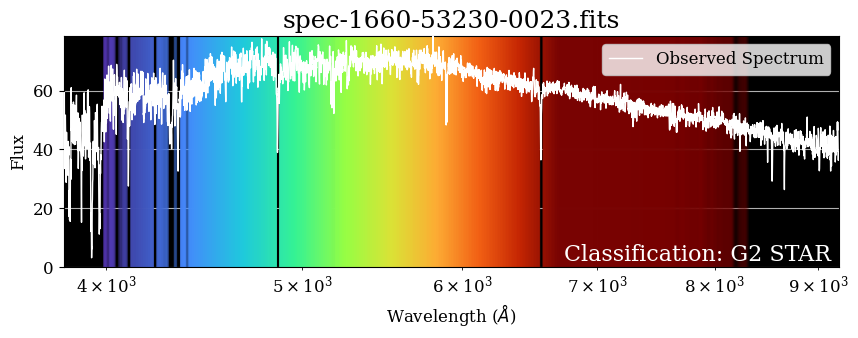

In [15]:
# Initiate plot
fig, ax = plt.subplots(figsize=(10, 3))

wavelength = 10 ** spectrum_file["COADD"].data["loglam"]
observed_flux = spectrum_file["COADD"].data["FLUX"]
model_flux = spectrum_file["COADD"].data["MODEL"]

plt.plot(wavelength, observed_flux, c="w", label="Observed Spectrum", zorder=4)

plt.grid()

# Add classification label
classification = spectrum_file["SPECOBJ"].data["CLASS"][0]
subclass = spectrum_file["SPECOBJ"].data["SUBCLASS"][0]
ax.text(
    0.99,
    0.1,
    f"Classification: {subclass} {classification}",
    fontsize=16,
    ha="right",
    va="top",
    color="w",
    transform=ax.transAxes,
)

plot_rainbow_background(ax, wavelength, model_flux)

# Label axes
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Flux")
plt.legend(loc="upper right")
plt.title(f"{spectrum_file.filename().strip('./')}")

# Set axes limits
plt.xlim(np.min(wavelength), np.max(wavelength))
plt.ylim(0, np.max(observed_flux))
plt.xscale("log")

# Show plot
plt.show()

It looks pretty! We can see how the background corresponds to the flux values, and the absorption features in the spectrum stick out as vertical black lines in the background. The shortest wavelengths (purple) tend to be brighter than the longest wavelengths (red), but this particular star peaks in green wavelengths, just like our Sun!


***

## Exploring Different Spectral Classifications

Now that we know what the spectrum of a G-type star like the Sun looks like, let's explore the other types of stars! In 1912, astronomer Annie Jump Cannon developed a method to classify stars based on the appearance of their spectrum, which is still used today. Stars are classified as O, B, A, F, G, K, or M based on the strength and location of absorption lines in their spectrum. [[1]](https://articles.adsabs.harvard.edu/pdf/1912AnHar..56..115C) 

In this section, we have made a list of stars with different spectral types to plot and explore:

In [16]:
star_list = [
    {  # O-Star example
        "obs_id": "sdss_spectro_2929-54616-0363",
        "spec_file": "spec-2929-54616-0363.fits",
        "label": "",
    },
    {  # B-star example
        "obs_id": "sdss_spectro_2871-54536-0542",
        "spec_file": "spec-2871-54536-0542.fits",
        "label": "",
    },
    {  # White Dwarf-star example
        "obs_id": "sdss_spectro_2630-54327-0551",
        "spec_file": "spec-2630-54327-0551.fits",
        "label": "White Dwarf Star. ",
    },
    {  # A-star example
        "obs_id": "sdss_spectro_2682-54401-0449",
        "spec_file": "spec-2682-54401-0449.fits",
        "label": "",
    },
    {  # F-star example
        "obs_id": "sdss_spectro_3298-54924-0214",
        "spec_file": "spec-3298-54924-0214.fits",
        "label": "",
    },
    {  # G-star example
        "obs_id": "sdss_spectro_1660-53230-0023",
        "spec_file": "spec-1660-53230-0023.fits",
        "label": "Sun-like Star. ",
    },
    {  # K-star example
        "obs_id": "sdss_spectro_3234-54885-0271",
        "spec_file": "spec-3234-54885-0271.fits",
        "label": "",
    },
    {  # M-star example
        "obs_id": "sdss_spectro_3298-54924-0159",
        "spec_file": "spec-3298-54924-0159.fits",
        "label": "",
    },
]

And here is a function to download the spectrum for each star using astroquery.MAST, just like we did earlier:

In [17]:
def download_spec(star: dict[str, str]) -> str:
    """Helper function for downloading SDSS Legacy Spectra Data from MAST"""
    # Search for spectrum in astroquery
    obs_table = Observations.query_criteria(obs_id=star["obs_id"])
    # Retrieve product list
    products = Observations.get_product_list(obs_table)
    # Download spectrum
    manifest = Observations.download_products(
        products, flat=True, verbose=False, mrp_only=True
    )
    return manifest["Local Path"][0]

Now we're ready to plot all of our stars:

Plotting star 1/8...


Plotting star 2/8...


Plotting star 3/8...


Plotting star 4/8...


Plotting star 5/8...


Plotting star 6/8...


INFO: Found cached file ./spec-1660-53230-0023.fits with expected size 604800. [astroquery.query]


Plotting star 7/8...


Plotting star 8/8...


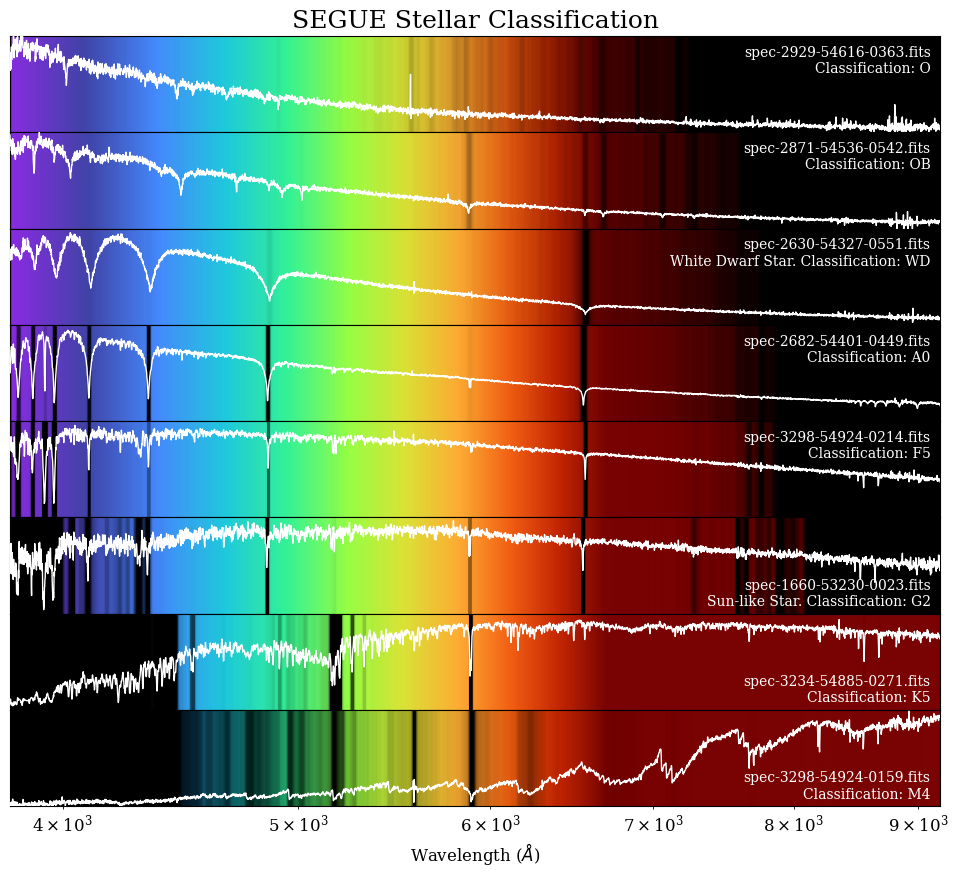

In [18]:
fig = plt.figure(figsize=(12, 10))

# Define a custom rainbow colormap to use for the spectrum
rainbow_colormap = LinearSegmentedColormap.from_list(
    "",
    ["blueviolet"] + [mpl.cm.turbo(x) for x in np.linspace(0.07, 0.999, 10)],
)

for star_i, star in enumerate(star_list):
    print(f"Plotting star {star_i + 1}/{len(star_list)}...")
    # Download Spectrum File
    spectrum_file = download_spec(star)
    # Open spectrum file
    spectrum_file = fits.open(spectrum_file)
    classification = spectrum_file["SPECOBJ"].data["SUBCLASS"][0]

    # Initiate plot
    ax = plt.subplot(len(star_list), 1, star_i + 1)
    wavelength = 10 ** spectrum_file["COADD"].data["loglam"]
    observed_flux = spectrum_file["COADD"].data["FLUX"]
    model_flux = spectrum_file["COADD"].data["MODEL"]

    ax.plot(
        wavelength, observed_flux, c="w", label="Observed Spectrum", zorder=3
    )

    # Start with a black background
    ax.axvspan(np.min(wavelength), np.max(wavelength), color="k", zorder=0)

    plot_rainbow_background(ax, wavelength, observed_flux)

    # Label axes
    if star_i < 5:
        y = 0.90
        va = "top"
    else:
        y = 0.05
        va = "bottom"

    ax.text(
        0.99,
        y,
        f"{star['spec_file']}\n{star['label']}Classification: {classification}",
        fontsize=10,
        ha="right",
        va=va,
        color="w",
        transform=ax.transAxes,
    )

    # Add plot title
    if star_i == 0:
        ax.set_title("SEGUE Stellar Classification")

    # Set axes limits
    ax.set_xlim(np.min(wavelength), np.max(wavelength))
    ax.set_xscale("log")
    ax.set_ylim(-0.1, np.percentile(observed_flux, 99) * 1.1)
    ax.yaxis.set_visible(False)  # Hide y-axis labels

    if star_i == len(star_list) - 1:
        ax.set_xlabel(r"Wavelength ($\AA$)")
    else:
        ax.xaxis.set_visible(False)  # Hide x axis labels

# Adjust subplots so there is no white space between the spectra
plt.subplots_adjust(hspace=0)

# Display plot
plt.savefig("segue_spectra.png", bbox_inches="tight")
plt.show()

This shows what the spectra look like for different types of stars! We can see how the color varies from the hottest stars (top), which have the strongest purple, and the cooler stars (bottom), which have the strongest reds. A-type stars have the strongest Hydrogen lines, while M-type stars have giant absorption bands made by molecules. Now you know how to classify stars based on these example spectra!


***

## Exercise: Classifying a Random Spectrum

Now that you know what different spectra of different types of stars look like, let's try classifying one by ourselves. To start, we will select a random star from SEGUE using the code in this cell:

In [19]:
# Querying SDSS SEGUE data
spectro_data = Observations.query_criteria(
    provenance_name="SEGUE",
    target_classification="STAR",
    pagesize=100,
    page=1,
)

# Choose a random entry from the results:
i = np.random.choice(range(len(spectro_data)))
my_random_star = spectro_data[i]

# Display result
my_random_star

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str4,str5,str17,str4,str4,str7,str19,str4,str28,float64,float64,str8,str18,int64,float64,float64,float64,float64,float64,str51,float64,str3,str1,int64,str48,str69,str64,str6,bool,float64,str9,str10
science,SDSS,SEGUE,SDSS Spectrograph,SDSS,None,OPTICAL,SDSS 3262-54884-85,STAR,sdss_spectro_3262-54884-0085,156.17831,37.200455,spectrum,SDSS Collaboration,3,54884.170856481476,54884.26603009259,7203.0,380.0,920.0,Sloan Digital Sky Survey (SDSS) Legacy Spectra Data,55572.0,N/A,--,--,CIRCLE 156.17831 37.200455 0.0004166666666666667,mast:SDSS/sdss/spectro/3262/54884/0085/spec-image-3262-54884-0085.png,mast:SDSS/sdss/spectro/3262/54884/0085/spec-3262-54884-0085.fits,PUBLIC,False,nan,353872032,1013303848


Now, it's time to practice what you've learned. In the following cell, write a bit of code that will download the spectrum for this star: 

In [20]:
# Use astroquery.mast to download the spectrum for this star

And use it to make a plot:

In [21]:
# Plot the spectrum

Compare this spectrum to the examples in the plot we made earlier in this notebook. What kind of star do you think this is? How can you check your answer?

In [22]:
# After making a guess, see what type of star this is:

***

### Exercise Solutions


In [23]:
# # Use astroquery.mast to download the spectrum for this star
# products = Observations.get_product_list(my_random_star)
# manifest = Observations.download_products(
#     products, flat=True, verbose=False, mrp_only=True
# )

In [24]:
# # Plot the spectrum
# spectrum_file = fits.open(manifest["Local Path"][0])

# fig, ax = plt.subplots(figsize=(10, 3))

# wavelength = 10 ** spectrum_file["COADD"].data["loglam"]
# observed_flux = spectrum_file["COADD"].data["FLUX"]
# model_flux = spectrum_file["COADD"].data["MODEL"]

# # Plot spectra
# plt.plot(wavelength, observed_flux, c="gray", label="Observed Spectrum")
# plt.plot(wavelength, model_flux, c="k", label="Model Spectrum")

# # Label axes
# ax.set_xlabel(r"Wavelength ($\AA$)")
# ax.set_ylabel("Flux")
# ax.set_title(f"{spectrum_file.filename().strip('./')}")
# ax.grid()
# plt.legend()

# # Set axes limits
# ax.set_xlim(np.min(wavelength), np.max(wavelength))
# ax.set_ylim(0, 1.1 * np.max(model_flux))

# # Show plot
# plt.show()

In [25]:
# # After making a guess, see what type of star this is:
# classification = spectrum_file["SPECOBJ"].data["SUBCLASS"][0]
# print(f"Classification: {classification}")

***

## Additional Resources

Additional resources are linked below:

- [SDSS Legacy Archive at MAST](https://archive.stsci.edu/missions-and-data/sdss)
- [SDSS Legacy Archive at MAST User Manual](https://outerspace.stsci.edu/display/SDSS/The+SDSS+Legacy+Archive+at+MAST)
- [SDSS Legacy Spectra User Manual](https://outerspace.stsci.edu/spaces/SDSS/pages/352354561/Legacy+Spectra+and+SEGUE)
- [astroquery.mast User Manual](https://astroquery.readthedocs.io/en/latest/mast/mast.html)
- [MAST API](https://mast.stsci.edu/api/v0/index.html)

## Citations

If you use SDSS Legacy Spectra or SEGUE data from MAST for published research, please see the following links for information on which citations to include in your paper:

* [Citing SDSS](https://sdss.org/collaboration/citing-sdss/)
* [Citing MAST](https://archive.stsci.edu/publishing/mission-acknowledgements)
* [Citing astropy](https://www.astropy.org/acknowledging.html)

## About this Notebook

**Author:** Julie Imig (jimig@stsci.edu)<br>
**Keywords:** Tutorial, SDSS, SEGUE, stars, spectra <br>
**First published:** October 2025 <br>
**Last updated:** October 2025 <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/style-guides/master/guides/images/stsci-logo.png" alt="Space Telescope Logo" width="200px"/> 